In [126]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries
from pathlib import Path
import os
import pickle
from functools import partial

# Save Results

## Load mlflow runs

In [127]:
results_dir = Path.cwd().parent / "results" / "gnoise"
os.makedirs(results_dir, exist_ok=True)

In [128]:
db_port = 5101
db_name = "cohirf"
url = f"postgresql://beluccib@localhost:{db_port}/{db_name}"
# url = f"postgresql://beluccib@clust5:{db_port}/{db_name}"
engine = create_engine(url)
query = "SELECT experiments.name from experiments"
experiment_names = pd.read_sql(query, engine)["name"].tolist()

In [129]:
experiment_names

['Default',
 'real-adjusted_rand-KernelRBFKMeans',
 'real-adjusted_rand-BatchCoHiRF-KernelRBF-1iter',
 'real-adjusted_rand-KMeans',
 'real-adjusted_rand-DBSCAN',
 'real-adjusted_rand-CoHiRF-DBSCAN',
 'real-adjusted_rand-BatchCoHiRF',
 'real-adjusted_rand-CoHiRF',
 'real-adjusted_rand-CoHiRF-KernelRBF',
 'real-adjusted_rand-BatchCoHiRF-DBSCAN-1iter',
 'real-davies_bouldin_score-BatchCoHiRF-1iter',
 'real-adjusted_mutual_info-BatchCoHiRF-KernelRBF-1iter',
 'real-silhouette-BatchCoHiRF-1iter',
 'real-silhouette-DBSCAN',
 'real-calinski_harabasz_score-BatchCoHiRF-1iter',
 'real-davies_bouldin_score-KernelRBFKMeans',
 'real-silhouette-KMeans',
 'real-davies_bouldin_score-KMeans',
 'real-calinski_harabasz_score-CoHiRF',
 'real-adjusted_mutual_info-BatchCoHiRF-DBSCAN-1iter',
 'real-davies_bouldin_score-BatchCoHiRF-KernelRBF-1iter',
 'real-adjusted_mutual_info-CoHiRF',
 'real-adjusted_mutual_info-CoHiRF-KernelRBF',
 'real-davies_bouldin_score-CoHiRF-DBSCAN',
 'real-adjusted_mutual_info-CoHiRF-

In [130]:
experiments_names = [exp for exp in experiment_names if exp.startswith("gnoise-")]

In [131]:
experiments_names

['gnoise-CoHiRF-1000',
 'gnoise-CoHiRF',
 'gnoise-KMeans',
 'gnoise-CoHiRF-top-down-inv',
 'gnoise-CoHiRF-top-down']

In [132]:
query = "SELECT DISTINCT(key) FROM params WHERE key LIKE 'best/%%'"
best_params = pd.read_sql(query, engine)["key"].tolist()

In [133]:
params_columns = [
    "model",
	"n_trials",
	"n_samples",
	"n_features_dataset",
	"n_random_features",
	"n_informative_features",
	"pct_random_features",
	"n_centers",
	"distance",
	"std",
	"seed_dataset",
	"standardize",
	"hpo_metric",
	"direction",
	"hpo_seed",
] + best_params

In [134]:
latest_metrics_columns = [
    "fit_model_return_elapsed_time",
    "max_memory_used_after_fit",
    "max_memory_used",
	"best/n_clusters_",
    "best/rand_score",
    "best/adjusted_rand",
    "best/mutual_info",
    "best/adjusted_mutual_info",
    "best/normalized_mutual_info",
    "best/homogeneity_completeness_v_measure",
    "best/silhouette",
    "best/calinski_harabasz_score",
    "best/davies_bouldin_score",
    "best/inertia_score",
    "best/homogeneity",
    "best/completeness",
    "best/v_measure",
    "best/elapsed_time",
]

In [135]:
tags_columns = ["raised_exception", "EXCEPTION", "mlflow.parentRunId", "Last step finished"]

In [136]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [137]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)
df_runs_raw.to_csv(results_dir / 'df_runs_raw_gnoise.csv', index=True)

In [138]:
df_runs_raw = pd.read_csv(results_dir / "df_runs_raw_gnoise.csv", index_col=0)
# mask = df_runs_raw["model"].str.contains("CoHiRF")
# df_runs_raw.loc[mask, "model"] = df_runs_raw.loc[mask].apply(lambda row: f"{row['model']}-{row['n_trials']}", axis=1)
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents["mlflow.parentRunId"].isna()]

/tmp/ipykernel_1258/432919028.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_runs_raw = pd.read_csv(results_dir / "df_runs_raw_gnoise.csv", index_col=0)


In [139]:
df_runs_raw_parents.head(5)

,status,start_time,end_time,best/child_run_id,best/kmeans_n_clusters,best/n_clusters,best/n_features,best/repetitions,direction,distance,...,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,max_memory_used,max_memory_used_after_fit,Last step finished,mlflow.parentRunId,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
0027eecbeefd4d16b6e3fddae7f91f79,FINISHED,1761067871616,1.761068e+12,4022e56df25346d58ad61b70eaff50c5,5.0,NaN,0.625329,3.0,maximize,1.0,...,0.000360,0.733112,-0.073328,0.000360,166.853874,7942.108,7942.108,_on_train_end,NaN,False
0034fa98b72947dbb51c094f8b71d750,FINISHED,1760980190983,1.760980e+12,e09e6ce34ef844a495d854a296883a03,NaN,5.0,NaN,NaN,maximize,20.0,...,0.780469,0.945427,0.197428,0.780469,12.504199,338.804,338.804,_on_train_end,NaN,False
009052a71ccf4e7680b2de11b1b82a20,FINISHED,1761067275282,1.761067e+12,8775c47cbe31486fa276fa6fbcb0c201,4.0,NaN,0.915852,2.0,maximize,1.0,...,0.037533,0.687284,-0.007126,0.037533,37.266029,441.404,441.404,_on_train_end,NaN,False
00a845b5002c4091b2f50873732e957c,FINISHED,1761067817507,1.761068e+12,4307e2f415e1485e8cbc1e30d6f65f5c,5.0,NaN,0.991929,2.0,maximize,1.0,...,0.052664,0.695008,0.049613,0.052664,130.925796,5693.516,5693.516,_on_train_end,NaN,False
00ba7aded92a458f93e41a2679fc2c33,FINISHED,1761067991577,1.761068e+12,dcfd1b274b53424fa9313fd278d73574,NaN,9.0,NaN,NaN,maximize,1.0,...,0.000572,0.733421,0.051533,0.000572,29.817264,347.944,347.944,_on_train_end,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [140]:
non_duplicate_columns = [
	"model",
    "n_samples",
	"n_features_dataset",
	"n_random_features",
	"n_informative_features",
	"pct_random_features",
	"n_centers",
	"distance",
	"std",
	"seed_dataset",
	"standardize",
	"hpo_seed",
]
# df_runs_parents.loc[df_runs_parents["best/n_clusters_"]*0.5 > df_runs_parents["n_instances"], "best/adjusted_rand"] = 
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how="all", subset=["best/adjusted_rand"]).copy()
# add back runs that were not evaluated because we judged too many clusters (but they run anyway)
# df_valid_runs = df_runs_raw_parents.loc[df_runs_raw_parents["best/n_clusters_"] > df_runs_raw_parents["n_instances"]*0.5].copy()
# df_runs_parents = pd.concat([df_runs_parents, df_valid_runs], axis=0)
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]
# fill missing values with "None"
df_runs_parents = df_runs_parents.fillna("None")

In [141]:
# get number of children runs that raised exception for each parent run
children_exceptions = df_runs_raw.groupby("mlflow.parentRunId")["raised_exception"].sum()
df_runs_parents["n_children_raised_exception"] = df_runs_parents.index.map(children_exceptions).fillna(0)

In [142]:
# df_to_cat = []
# hpo_metrics = [
#     "adjusted_rand",
#     "adjusted_mutual_info",
#     "calinski_harabasz_score",
#     "silhouette",
#     "davies_bouldin_score",
#     "normalized_mutual_info",
# ]
# standardize = [True]
# hpo_seed = [i for i in range(5)]
# fill_value = pd.NA
# fill_columns = ["best/adjusted_rand", "best/adjusted_mutual_info", "best/calinski_harabasz_score", "best/silhouette", "best/davies_bouldin_score", "best/normalized_mutual_info"]
# df_runs_parents = pd.concat([df_runs_parents, pd.DataFrame(df_to_cat)], axis=0)

# Missing

In [143]:
model_nickname = df_runs_parents['model'].unique().tolist()
model_nickname.sort()
model_nickname

['CoHiRF', 'CoHiRF-1000', 'CoHiRF-top-down', 'CoHiRF-top-down-inv', 'KMeans']

In [144]:
non_duplicate_columns = [
	"model",
    "n_samples",
    "n_informative_features",
    "n_centers",
    "std",
    "hpo_seed",
	"standardize",
	"hpo_metric",
]

In [145]:
model_nickname = ["CoHiRF", "CoHiRF-1000", "CoHiRF-top-down", "CoHiRF-top-down-inv", "KMeans"]
n_samples = [1000, 10000]
n_informative_features = [100, 1000, 10000]
n_centers = [5]
std = [1.0, 3.0, 5.0, 10.0, 30.0, 50.0]
hpo_seed = [i for i in range(3)]
standardize = [True, False]
hpo_metric = ["adjusted_rand"]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_informative_features, n_centers, std, hpo_seed, standardize, hpo_metric]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)
df_missing

,model,n_samples,n_informative_features,n_centers,std,hpo_seed,standardize,hpo_metric


In [146]:
model_nickname = ["CoHiRF", "CoHiRF-1000", "CoHiRF-top-down", "CoHiRF-top-down-inv", "KMeans"]
n_samples = [1000]
n_informative_features = [100, 1000, 10000]
n_centers = [5]
std = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]
hpo_seed = [i for i in range(5)]
standardize = [False]
hpo_metric = ["adjusted_rand"]
columns_names = non_duplicate_columns
should_contain_values = [
    model_nickname,
    n_samples,
    n_informative_features,
    n_centers,
    std,
    hpo_seed,
    standardize,
    hpo_metric,
]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)
df_missing

,model,n_samples,n_informative_features,n_centers,std,hpo_seed,standardize,hpo_metric


In [ ]:
# Join df_runs_raw_parents into df_missing using non_duplicate_columns to get the EXCEPTION column
df_missing_with_exception = df_missing.merge(
    df_runs_raw_parents[non_duplicate_columns + ["raised_exception", "Last step finished"]],
    how="left",
    left_on=non_duplicate_columns,
    right_on=non_duplicate_columns,
)
df_missing_with_exception[
    non_duplicate_columns + [
        "raised_exception",
        # "EXCEPTION",
        "Last step finished",
    ]
]

,model,n_samples,n_informative_features,n_centers,std,hpo_seed,standardize,hpo_metric,raised_exception,Last step finished
0,CoHiRF,10000,100,5,1.0,0,False,adjusted_rand,NaN,NaN
1,CoHiRF,10000,100,5,1.0,1,False,adjusted_rand,NaN,NaN
2,CoHiRF,10000,100,5,1.0,2,False,adjusted_rand,NaN,NaN
3,CoHiRF,10000,100,5,3.0,0,False,adjusted_rand,NaN,NaN
4,CoHiRF,10000,100,5,3.0,1,False,adjusted_rand,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
158,CoHiRF-top-down-inv,10000,10000,5,30.0,1,False,adjusted_rand,NaN,NaN
159,CoHiRF-top-down-inv,10000,10000,5,30.0,2,False,adjusted_rand,NaN,NaN
160,CoHiRF-top-down-inv,10000,10000,5,50.0,0,False,adjusted_rand,NaN,NaN
161,CoHiRF-top-down-inv,10000,10000,5,50.0,1,False,adjusted_rand,NaN,NaN


In [121]:
df_missing_dict = df_missing.copy()
# get only rows from high_mem_tuples
# df_missing_dict = df_missing_dict.merge(high_mem_tuples, on=["model", "dataset_id"], how="left", indicator=True)
# df_missing_dict = df_missing_dict[df_missing_dict["_merge"] == "both"].drop(columns="_merge")
# exclude rows that are in missing_ari_tuples
# df_missing_dict = df_missing_dict.merge(
# 	missing_ari_tuples, on=["model", "dataset_id"], how="left", indicator=True
# )|
# df_missing_dict = df_missing_dict[df_missing_dict["_merge"] == "left_only"].drop(columns="_merge")
# exclude rows that are in high_mem_tuples
# df_missing_dict = df_missing_dict.merge(
# 	high_mem_tuples, on=["model", "dataset_id"], how="left", indicator=True
# )
# df_missing_dict = df_missing_dict[df_missing_dict["_merge"] == "left_only"].drop(columns="_merge")
# to_drop = pd.concat([missing_ari_tuples, high_mem_tuples], ignore_index=True)
# df_missing_dict = df_missing_dict[df_missing_dict["_merge"] == "left_only"].drop(columns="_merge")

In [122]:
df_missing_dict["seed_dataset"] = df_missing_dict["hpo_seed"]

In [123]:
df_missing_dict

,model,n_samples,n_informative_features,n_centers,std,hpo_seed,standardize,hpo_metric,seed_dataset
0,CoHiRF,1000,100,5,5.0,3,False,adjusted_rand,3
1,CoHiRF,1000,100,5,5.0,4,False,adjusted_rand,4
2,CoHiRF,1000,100,5,10.0,3,False,adjusted_rand,3
3,CoHiRF,1000,100,5,10.0,4,False,adjusted_rand,4
4,CoHiRF,1000,100,5,15.0,0,False,adjusted_rand,0
...,...,...,...,...,...,...,...,...,...
460,KMeans,1000,10000,5,40.0,0,False,adjusted_rand,0
461,KMeans,1000,10000,5,40.0,1,False,adjusted_rand,1
462,KMeans,1000,10000,5,40.0,2,False,adjusted_rand,2
463,KMeans,1000,10000,5,40.0,3,False,adjusted_rand,3


In [124]:
missing_dict = {}
for model in df_missing_dict["model"].unique():
    sub = df_missing_dict[df_missing_dict["model"] == model].drop(columns=["model"])
    # standardize = True
    sub_standardized = sub.loc[sub["standardize"] == True].copy()
    sub_standardized["standardize"] = ''
    sub_standardized_dict = sub_standardized.to_dict(orient="records")
    # standardize = False
    sub_not_standardized = sub.loc[sub["standardize"] == False].copy()
    sub_not_standardized.drop(columns=["standardize"], inplace=True)
    sub_not_standardized_dict = sub_not_standardized.to_dict(orient="records")
    # combine both dictionaries
    missing_dict[model] = sub_standardized_dict + sub_not_standardized_dict
if len(missing_dict) != 0:
    with open(results_dir / 'missing_dict.pkl', 'wb') as f:
        pickle.dump(missing_dict, f)

In [125]:
missing_dict

{'CoHiRF': [{'n_samples': 1000,
   'n_informative_features': 100,
   'n_centers': 5,
   'std': 5.0,
   'hpo_seed': 3,
   'hpo_metric': 'adjusted_rand',
   'seed_dataset': 3},
  {'n_samples': 1000,
   'n_informative_features': 100,
   'n_centers': 5,
   'std': 5.0,
   'hpo_seed': 4,
   'hpo_metric': 'adjusted_rand',
   'seed_dataset': 4},
  {'n_samples': 1000,
   'n_informative_features': 100,
   'n_centers': 5,
   'std': 10.0,
   'hpo_seed': 3,
   'hpo_metric': 'adjusted_rand',
   'seed_dataset': 3},
  {'n_samples': 1000,
   'n_informative_features': 100,
   'n_centers': 5,
   'std': 10.0,
   'hpo_seed': 4,
   'hpo_metric': 'adjusted_rand',
   'seed_dataset': 4},
  {'n_samples': 1000,
   'n_informative_features': 100,
   'n_centers': 5,
   'std': 15.0,
   'hpo_seed': 0,
   'hpo_metric': 'adjusted_rand',
   'seed_dataset': 0},
  {'n_samples': 1000,
   'n_informative_features': 100,
   'n_centers': 5,
   'std': 15.0,
   'hpo_seed': 1,
   'hpo_metric': 'adjusted_rand',
   'seed_dataset': 

# Graphs

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [148]:
def plot_results(df, x_axis_label, y_axis_label_metric, y_axis_label_time, time, log_time=False):
	df = df.copy()  # To avoid modifying the original DataFrame
	df.rename(
		columns={"std": x_axis_label, "best/adjusted_rand": y_axis_label_metric, time: y_axis_label_time, "model": "Model"},
		inplace=True,
	)
	plt.style.use("seaborn-v0_8-whitegrid")
	with mpl.rc_context(
		rc={
			"figure.constrained_layout.use": True,
			"savefig.bbox": "tight",
			"figure.figsize": (12, 7),
			"legend.loc": "upper left",
			"legend.frameon": True,
			"font.size": 14,
			"axes.titlesize": 16,
			"axes.labelsize": 15,
			"xtick.labelsize": 13,
			"ytick.labelsize": 13,
			"axes.grid": True,
			"grid.color": "grey",
			"grid.alpha": 0.3,
		}
	):
		fig, axs = plt.subplots(2, 1, sharex=True)
		axs = axs.flatten()
		palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
		# Time plot
		ax = sns.lineplot(
			data=df,
			x=x_axis_label,
			y=y_axis_label_time,
			hue="Model",
			style="Model",
			markers=True,
			dashes=False,
			errorbar="ci",
			ax=axs[0],
			palette=palette,
			hue_order=sorted(df["Model"].unique()),
		)
		if log_time:
			ax.set_yscale("log")
		ax.set_ylabel(y_axis_label_time)
		ax.grid(True, which="both", linestyle="--", linewidth=0.5)
		# ARI plot
		ax2 = sns.lineplot(
			data=df,
			x=x_axis_label,
			y=y_axis_label_metric,
			hue="Model",
			style="Model",
			markers=True,
			dashes=False,
			errorbar="ci",
			ax=axs[1],
			palette=palette,
		)
		ax2.set_ylabel(y_axis_label_metric)
		ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
		# Remove duplicate legends
		handles, labels = ax.get_legend_handles_labels()
		fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
		ax.get_legend().remove()
		ax2.get_legend().remove()
		plt.xlabel(x_axis_label)
		return fig, axs

In [149]:
def plot_results_grid(df, x_axis_label, y_axis_label_metric, y_axis_label_time, time, log_time=False):
    """
    Plot results using seaborn relplot with grid layout:
    - Rows: n_samples
    - Columns: n_informative_features  
    - Two separate figures: one for time, one for ARI
    """
    df = df.copy()
    df.rename(
        columns={"std": x_axis_label, "best/adjusted_rand": y_axis_label_metric, time: y_axis_label_time, "model": "Model"},
        inplace=True,
    )

    plt.style.use("seaborn-v0_8-whitegrid")

    # Set up the plotting context
    with mpl.rc_context(
        rc={
            "font.size": 10,
            "axes.titlesize": 10,
            "axes.labelsize": 9,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            "legend.fontsize": 8,
            "axes.grid": True,
            "grid.color": "grey",
            "grid.alpha": 0.3,
        }
    ):
        palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))

        # Plot 1: Time
        g1 = sns.relplot(
            data=df,
            x=x_axis_label,
            y=y_axis_label_time,
            hue="Model",
            style="Model",
            col="n_informative_features",
            row="n_samples",
            kind="line",
            markers=True,
            dashes=False,
            errorbar="ci",
            palette=palette,
            hue_order=sorted(df["Model"].unique()),
            facet_kws={"sharex": True, "sharey": False},
            height=3,
            aspect=1.0,
        )

        # Configure time plot
        if log_time:
            for ax in g1.axes.flat:
                ax.set_yscale("log")

        g1.set_axis_labels(x_axis_label, y_axis_label_time)
        g1.set_titles(col_template="n_informative_features = {col_name}", 
                     row_template="n_samples = {row_name}",
                     size=9)

        # move legend
        sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))

        # Add grid to all subplots
        for ax in g1.axes.flat:
            ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        # Plot 2: ARI
        g2 = sns.relplot(
            data=df,
            x=x_axis_label,
            y=y_axis_label_metric,
            hue="Model",
            style="Model",
            col="n_informative_features",
            row="n_samples",
            kind="line",
            markers=True,
            dashes=False,
            errorbar="ci",
            palette=palette,
            hue_order=sorted(df["Model"].unique()),
            facet_kws={"sharex": True, "sharey": False},
            height=3,
            aspect=1.0
        )

        # Configure ARI plot
        g2.set_axis_labels(x_axis_label, y_axis_label_metric)
        g2.set_titles(col_template="n_informative_features = {col_name}", 
                     row_template="n_samples = {row_name}",
                     size=9)

        # move legend
        sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))

        # Add grid to all subplots
        for ax in g2.axes.flat:
            ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        return g1, g2

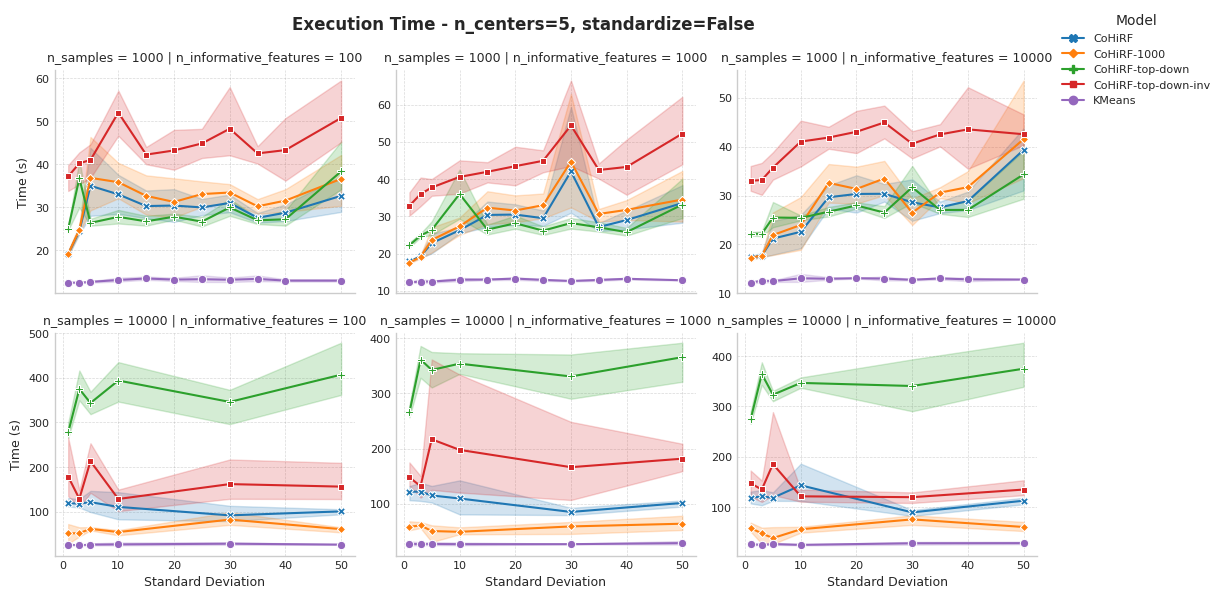

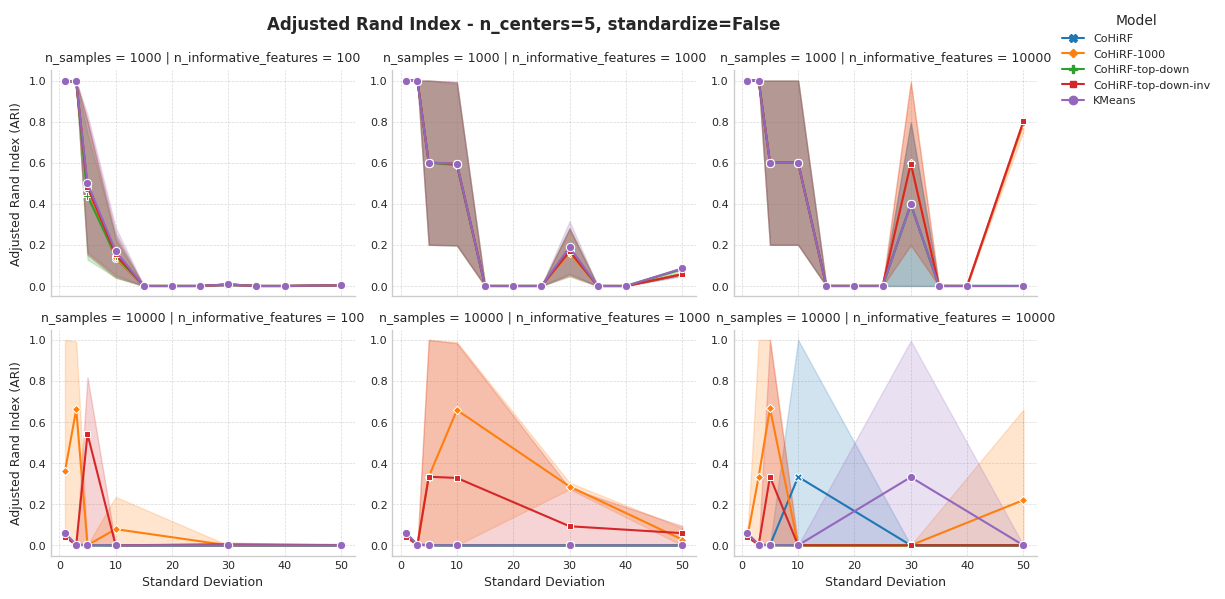

In [150]:
# Example usage of the grid plotting function
n_centers = 5
standardize = False

# Filter data for the grid plot
df_grid = df_runs_parents.copy()        
df_grid = df_grid.loc[
    (df_grid["n_centers"] == n_centers)
    & (df_grid["standardize"] == standardize)
    # & (df_grid["std"] <= 10)
]

# Create the grid plots
g1, g2 = plot_results_grid(
    df_grid, 
    "Standard Deviation", 
    "Adjusted Rand Index (ARI)", 
    "Time (s)", 
    "fit_model_return_elapsed_time", 
    log_time=False
)

# Add overall titles with proper spacing
g1.figure.suptitle(f"Execution Time - n_centers={n_centers}, standardize={standardize}", 
                fontsize=12, fontweight='bold')
g2.figure.suptitle(
    f"Adjusted Rand Index - n_centers={n_centers}, standardize={standardize}", fontsize=12, fontweight="bold"
)
g1.figure.tight_layout()
g2.figure.tight_layout()

plt.show()

In [41]:
df_runs_parents.n_samples.unique()

array([10000,  1000])

In [42]:
df_runs_parents.n_informative_features.unique()

array([  100, 10000,  1000])

/tmp/ipykernel_1258/3686133289.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


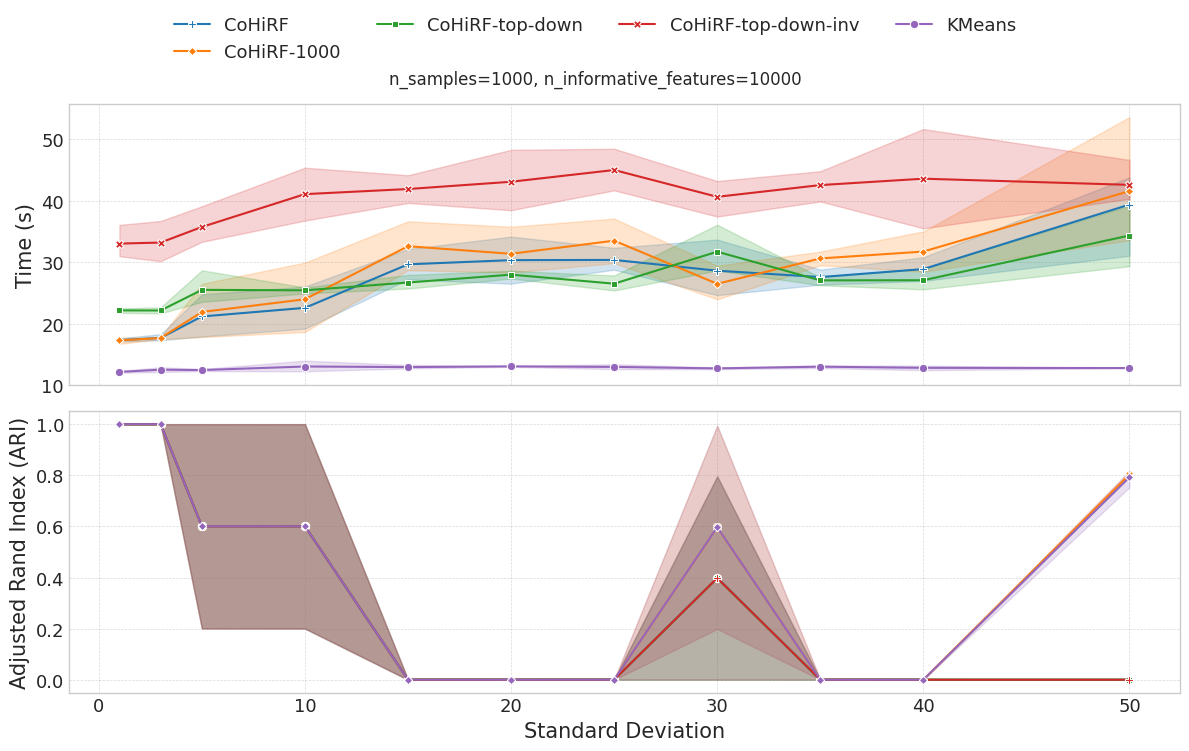

In [152]:
n_centers = 5
standardize = False
n_samples = 1000
n_informative_features = 10000
df = df_runs_parents.copy()        
df = df.loc[
    (df["n_samples"] == n_samples)
    & (df["n_informative_features"] == n_informative_features)
    & (df["n_centers"] == n_centers)
    & (df["standardize"] == standardize)
    # & (df["std"] <= 10)
	# & (df["model"].isin([
	# 	'KMeans',
	# 	# 'CoHiRF',
	# 	# 'CoHiRF-1000',
    #     'CoHiRF-top-down',
	# 	'CoHiRF-top-down-inv',
    # ]))
]
fig, axs = plot_results(df, "Standard Deviation", "Adjusted Rand Index (ARI)", "Time (s)", "fit_model_return_elapsed_time", log_time=False)
fig.suptitle(f"n_samples={n_samples}, n_informative_features={n_informative_features}")
plt.tight_layout()
plt.show()

In [102]:
df.columns

Index(['status', 'start_time', 'end_time', 'best/child_run_id',
       'best/kmeans_n_clusters', 'best/n_clusters', 'best/n_features',
       'best/repetitions', 'direction', 'distance', 'hpo_metric', 'hpo_seed',
       'model', 'n_centers', 'n_features_dataset', 'n_informative_features',
       'n_random_features', 'n_samples', 'n_trials', 'pct_random_features',
       'seed_dataset', 'standardize', 'std', 'best/adjusted_mutual_info',
       'best/adjusted_rand', 'best/calinski_harabasz_score',
       'best/completeness', 'best/elapsed_time', 'best/homogeneity',
       'best/mutual_info', 'best/n_clusters_', 'best/normalized_mutual_info',
       'best/rand_score', 'best/silhouette', 'best/v_measure',
       'fit_model_return_elapsed_time', 'max_memory_used',
       'max_memory_used_after_fit', 'Last step finished', 'mlflow.parentRunId',
       'raised_exception', 'n_children_raised_exception'],
      dtype='object')

In [105]:
df[['model', 'std', 'best/adjusted_rand']].sort_values(by=['model', 'std'])

,model,std,best/adjusted_rand
run_uuid,,,
20e62105eb4c4c888445f506faecaeef,CoHiRF,1.0,1.000000
74433cb83bae43da8d109586fb4a92eb,CoHiRF,1.0,1.000000
d17146d0d8054fa0b63324cfcbf700d5,CoHiRF,1.0,1.000000
29cdb2bda7bb4740a0fcf0f40aefd588,CoHiRF,3.0,1.000000
ae2ca27ff94740b38021535e8eddd5a4,CoHiRF,3.0,1.000000
d72c89bfed13432299d945fcbcd0873b,CoHiRF,3.0,1.000000
085b6d70d0a648a4b240eb84f7910413,CoHiRF,5.0,1.000000
9294136abbe748e693d9006a99c8d495,CoHiRF,5.0,1.000000
d667eda9f1ea4be89e4120882fb95104,CoHiRF,5.0,1.000000


# Debug and explore

In [41]:
df = df_runs_raw_parents.copy()

In [59]:
df = df.loc[df["model"] == "BatchCoHiRF-DBSCAN-1iter-60"]
df = df.loc[df["dataset_id"] == 47039]

In [60]:
df

,status,start_time,end_time,best/base_model_kwargs/eps,best/base_model_kwargs/min_samples,best/base_model_kwargs/n_clusters,best/base_model_kwargs/n_similarities,best/base_model_kwargs/sampling_ratio,best/base_model_kwargs/sc_n_clusters,best/child_run_id,...,EXCEPTION,Last step finished,mlflow.parentRunId,raised_exception,dataset,openml_id,n_instances,n_features,n_classes,n_categorical
run_uuid,,,,,,,,,,,,,,,,,,,,,
0687a0e95efb434482a8174cda90d4cb,FINISHED,1759857341387,1.759883e+12,NaN,NaN,NaN,NaN,NaN,NaN,11edf35ba2aa4e67bfbda1a2e60600a4,...,NaN,_on_train_end,NaN,False,criteo-uplift-balanced,47039,1366544,14,4,2
194290e427024ea0a13f9ae54a19ad1d,FINISHED,1759857342388,1.759875e+12,NaN,NaN,NaN,NaN,NaN,NaN,5e6f3d3cf8c844f795bf7220090e113d,...,NaN,_on_train_end,NaN,False,criteo-uplift-balanced,47039,1366544,14,4,2
2d6bd7e8c4ba4385ba525787babef29a,FINISHED,1759746035261,1.759772e+12,NaN,NaN,NaN,NaN,NaN,NaN,cc9f24b21561489abf2010dfb6f18b20,...,NaN,_on_train_end,NaN,False,criteo-uplift-balanced,47039,1366544,14,4,2
3bb1b76f13684935a96c5f6921c1331d,FINISHED,1759857341387,1.759876e+12,NaN,NaN,NaN,NaN,NaN,NaN,92e2a42f740f494d955665bf6cd284df,...,NaN,_on_train_end,NaN,False,criteo-uplift-balanced,47039,1366544,14,4,2
3ce4ac0bd17943149fed033ad489646b,FINISHED,1759746035257,1.759761e+12,NaN,NaN,NaN,NaN,NaN,NaN,8b7dfabd8ba441ecba1950ade4c28e41,...,NaN,_on_train_end,NaN,False,criteo-uplift-balanced,47039,1366544,14,4,2
5136039b079740f39d60ff9070c2b98d,FINISHED,1759746035785,1.759792e+12,NaN,NaN,NaN,NaN,NaN,NaN,1d6e63c34e73416896a0976dba0d528f,...,NaN,_on_train_end,NaN,False,criteo-uplift-balanced,47039,1366544,14,4,2
5d063fc4745a4d70add5329b0640e06f,FINISHED,1759746033001,1.759769e+12,NaN,NaN,NaN,NaN,NaN,NaN,5e35df5e5f6e4572b12190e51a2ad5e8,...,NaN,_on_train_end,NaN,False,criteo-uplift-balanced,47039,1366544,14,4,2
71fea0d02579497b99daa7aaaf00a6bb,FAILED,1759510979843,1.759520e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Best metric adjusted_rand not found in the bes...,_before_evaluate_model,NaN,True,criteo-uplift-balanced,47039,1366544,14,4,2
85248d1527414425abd710547fe79470,FINISHED,1759671558525,1.759708e+12,NaN,NaN,NaN,NaN,NaN,NaN,4ac471428c644046a870cb5b0f7bca53,...,NaN,_on_train_end,NaN,False,criteo-uplift-balanced,47039,1366544,14,4,2


In [61]:
runs_to_delete_parents = list(df.index)
df = df_runs_raw.copy()
df = df.loc[df["mlflow.parentRunId"].isin(runs_to_delete_parents)]
runs_to_delete_children = list(df.index)
runs_to_delete = runs_to_delete_children + runs_to_delete_parents
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ", ".join(run_uuid_query)

In [62]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

In [63]:
query = f"""
DELETE
FROM
	experiment_tags
WHERE
	experiment_id = ANY(
	SELECT
		experiment_id
	FROM
		experiments
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	latest_metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	params
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	tags
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE 
FROM 
	runs
WHERE 
	lifecycle_stage = 'deleted';

DELETE 
FROM 
	experiments
WHERE 
	lifecycle_stage = 'deleted';
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    